<a href="https://colab.research.google.com/github/DonRomaniello/citibike_dock_availability/blob/master/CitiBike_Docks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Functions

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy
import geopy
import folium
from folium import plugins

import os
import time
import datetime

import requests
import json

import requests
import json
import tarfile
import os
import time
import datetime

In [59]:
# import
docks = pd.read_csv('https://zakalwe.s3.amazonaws.com/OldRound.csv.xz', compression='xz', index_col=0)
latlong = pd.read_csv('https://zakalwe.s3.amazonaws.com/distancefrom519.csv.xz', compression='xz', index_col=0)
docks.drop('Total Availability', axis=0, inplace=True)
latlong.index.rename('station_id', inplace=True)
id_latlong = latlong.copy(deep = True)
id_latlong.drop(3195, axis=0, inplace=True)
id_latlong = id_latlong.merge(docks, how='inner', on='station_id')

sigma45 = docks.T.rolling(45).std()
mu45 = docks.T.rolling(45).mean()

diffs45 = pd.read_csv('https://zakalwe.s3.amazonaws.com/diffs45.csv.xz', compression='xz', index_col=0).drop('Total Availability', axis=0).T
diffsigma45 = diffs45.rolling(45).std()
diffsmu45 = diffs45.rolling(45).mean()

#Trip data for 2019 for Station 519
five19 = pd.read_csv('https://zakalwe.s3.amazonaws.com/519in2019.csv.xz', compression='xz', index_col=0)

# Delete the feeder pandas
del docks
del latlong
del diffs45

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#Functions to return easily understood times
def day_of_year(epoch):
  yd = time.strftime('%j', time.localtime(int(epoch)))
  return yd

def day_of_week(epoch):
  wd = time.strftime('%w', time.localtime(int(epoch)))
  return wd

def time_of_day(epoch):
  tod = time.strftime('%H:%M', time.localtime(int(epoch)))
  return tod

def hour_of_day(epoch):
  hod = time.strftime('%M', time.localtime(int(epoch)))
  return hod

def month_day_time(epoch):
  mdt = time.strftime('%m/%d/%y %H:%M', time.localtime(int(epoch)))
  return mdt

def month_day_year(epoch):
  mdy = time.strftime('%m/%d/%y', time.localtime(int(epoch)))
  return mdy

def graph_time_labels(hourlist):
  labelprep = list(hourlist)
  labels = []
  for entry in labelprep:
    labels.append(str(entry).zfill(2) + ':' + '00')
  return labels

# And the reverse...
def epochreturn(mdy):
  timeformat = '%m/%d/%y %H:%M'
  epoch = str(int(time.mktime(time.strptime(mdy, timeformat))))
  return epoch

#Return epoch for x weeks from the day
def epoch_xweeks_from_day(startday, weeks):
  epoch = epochreturn(startday)
  day = time.strftime('%j', time.localtime(int(epoch)))
  year = time.strftime('%y', time.localtime(int(epoch)))
  intday = int(day)
  newday = str(intday + (7 * weeks)).zfill(3)
  timeformat = '%j %y'
  epochxweeks = str(int(time.mktime(time.strptime(newday + ' ' + year, timeformat))))
  return epochxweeks

def one_day_more(startday):
  epoch = epochreturn(startday)
  day = time.strftime('%j', time.localtime(int(epoch)))
  year = time.strftime('%y', time.localtime(int(epoch)))
  intday = int(day)
  newday = str(intday + 1).zfill(3)
  timeformat = '%j %y'
  one_day_more = str(int(time.mktime(time.strptime(newday + ' ' + year, timeformat))))
  return one_day_more

#A function to return the index location based on a human time format
def locreturn(dframe, timesay):
  location = dframe.index.get_loc(epochreturn(timesay))
  return location

#Fun with colors
def hex_color(R, G, B):
 hexcolor = '#' + str(hex(R)).replace('0x', '').zfill(2)[-2:] + str(hex(G)).replace('0x', '').zfill(2)[-2:] + str(hex(B)).replace('0x', '').zfill(2)[-2:]
 return hexcolor

def cmap_color(R, G, B):
 hexcolor = '#' + str(hex(R)).replace('0x', '').zfill(2)[-2:] + str(hex(G)).replace('0x', '').zfill(2)[-2:] + str(hex(B)).replace('0x', '').zfill(2)[-2:]
 return hexcolor

def lon_as_huevalue(lon):
  lonval = int((lon - id_latlong['lon'].min()) / ((id_latlong['lon'].max() - id_latlong['lon'].min()) / 255))
  return lonval

def lat_as_huevalue(lat):
  latval = int((lat - id_latlong['lat'].min()) / ((id_latlong['lat'].max() - id_latlong['lat'].min()) / 255))
  return latval

In [0]:
# Line plot settings
def linesettings():
  plt.figure(figsize=(20, 12), dpi= 72)
  plt.grid(True, axis='both')
  plt.xticks(np.arange(0, 1440, step=60), graph_time_labels(np.arange(0, 24, step=1)), rotation=45)
  plt.margins(x=0, y=.05)
  plt.xlabel('Time')
  plt.ylabel('Open Docks')


def sub2settings():
  plt.figure(figsize=(20, 6), dpi= 72)
  plt.grid(True, axis='both')
  plt.xticks(np.arange(0, 1440, step=60), graph_time_labels(np.arange(0, 24, step=1)), rotation=45)
  plt.margins(x=0, y=.05)
  plt.xlabel('Time')
  plt.ylabel('Open Docks')


def sub3settings():
  plt.figure(figsize=(20, 4), dpi= 72)
  plt.grid(True, axis='both')
  plt.xticks(np.arange(0, 1440, step=60), graph_time_labels(np.arange(0, 24, step=1)), rotation=45)
  plt.margins(x=0, y=.05)
  plt.xlabel('Time')
  plt.ylabel('Open Docks')

# Availability, Geographically




By weighting all the station locations by how many docks are available at any given hour, we can learn whether there are any geographical trends over time.

Is there an influx into Manhattan? An exodus?

In [0]:
def weightedcenter(colnum):

  avg_lat_list = []
  avg_lon_list = []

  for a in range(0, len(id_latlong.index)):
    avg_lat_list.append( (id_latlong.iloc[a, colnum]/id_latlong.iloc[:, colnum].sum() ) * lat_list[a])
    avg_lon_list.append( (id_latlong.iloc[a, colnum]/id_latlong.iloc[:, colnum].sum() ) * lon_list[a])

  weightlist = [float(sum(avg_lat_list)), float(sum(avg_lon_list))]

  return weightlist

In [0]:
lat_list = list(id_latlong.iloc[:,0])
lon_list = list(id_latlong.iloc[:,1])


weightcenter = folium.Map(
  location=[40.73684938723916, -73.9907947],
  tiles='Stamen Toner',
  zoom_start=12
)

In [0]:
# Add circles that correspond to the weighted center

for i in range(1440, 11520, 60):
  folium.Circle(
        location=weightedcenter(i),
        radius=10,
        color=hex_color(255, int((i/46)), int((255 - (i / 46)))),
        fill=True, 
        fill_color='#ff008c'
    ).add_to(weightcenter)

In [0]:
for i in range(0,len(id_latlong)):
  folium.Circle(
        location=[id_latlong.iloc[i]['lat'],id_latlong.iloc[i]['lon']],
        popup=str(id_latlong.index[i]),
        radius=10,
        color='#008cff',
        fill=True,
        fill_color='#008cff'
    ).add_to(weightcenter)

**Stations and Centers**

The blue circles are NYC Citibike stations.

The cluster of circles in the East River represent the midpoint of available docks over a week.  The earliest entries are more red, later centers are more yellow.

The system is very evenly distributed over time.

In [66]:
weightcenter

# **The System at Large...**

The atrocity depicted below represents the available docks for every station in the entire NYC system over a week. Notice the regular drop in activity (represented by straight lines) in the wee hours of the day.

The color map represents distance from Dock 519, the most active station in the system.

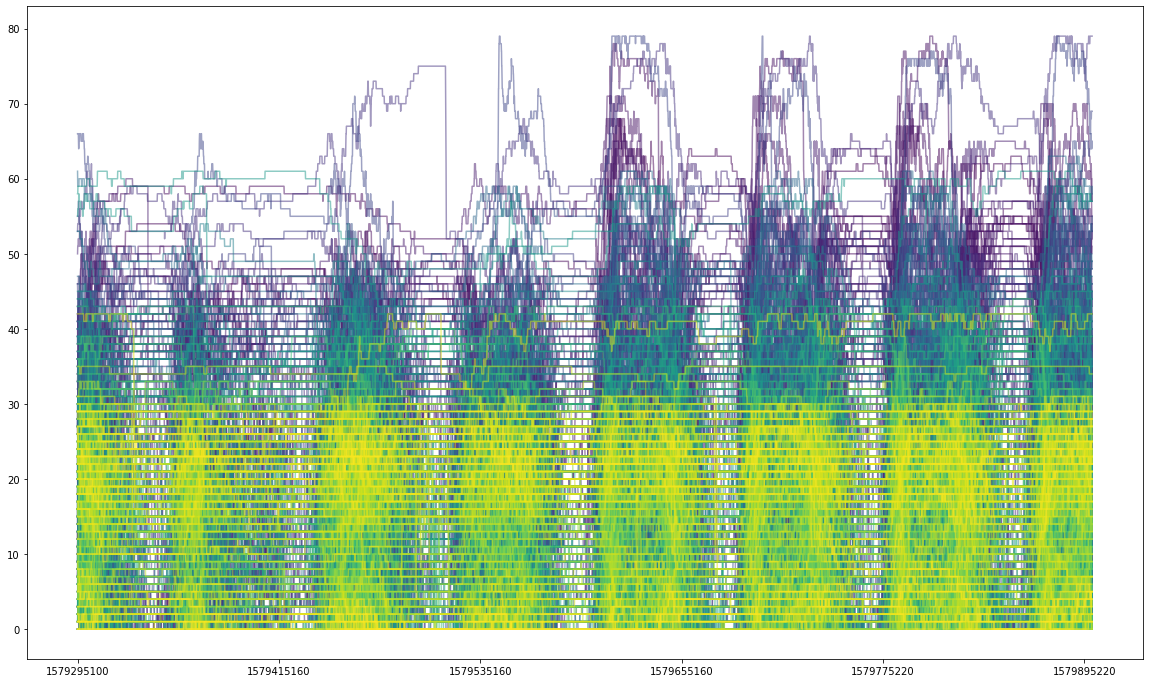

In [85]:
id_latlong.T[3:10083].plot(kind='line', alpha=.5, legend=False, figsize=(20,12), colormap='viridis')

# One Station's Story

In [86]:
# Station 519 is fed by many stations; 95% of the bikes come from 265 stations
print(str(100 * (sum(list(five19['ssid'].value_counts())[0:265]) / sum(list(five19['ssid'].value_counts())))) + '%')

95.06609402324864%


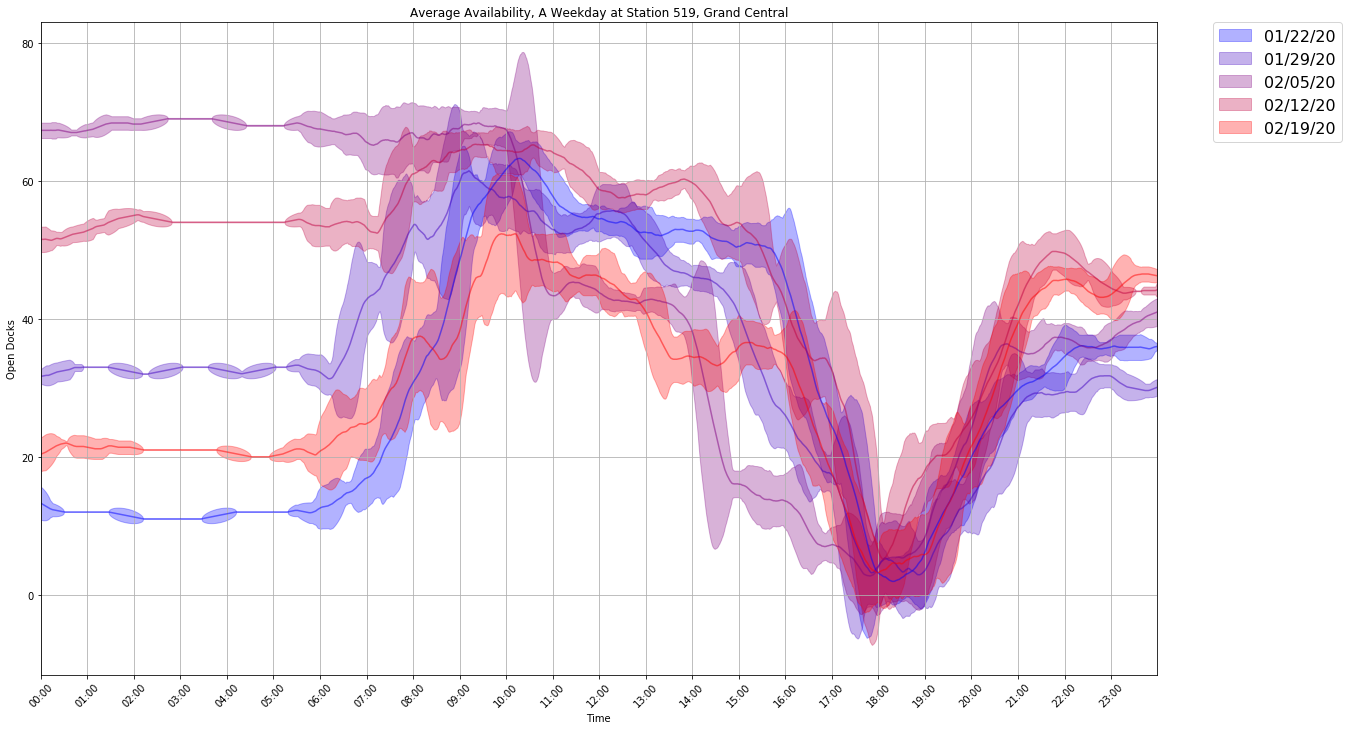

In [87]:
startday = '1/22/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 519
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

linesettings()

patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))

plt.legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title('Average Availability, A Weekday at Station 519, Grand Central')


# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))

  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )


  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

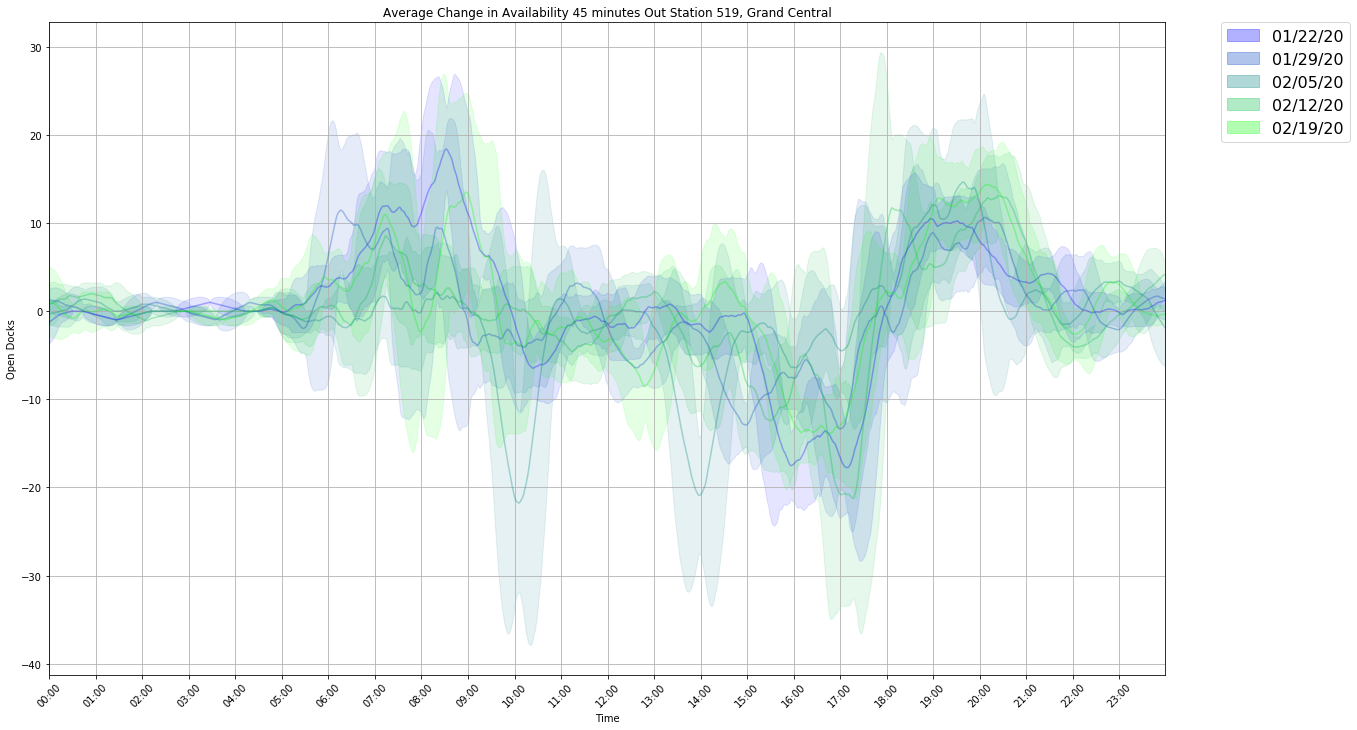

In [88]:
startday = '1/22/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 519
sigma = 2

timerange = [locreturn(diffsigma45, startday), locreturn(diffsigma45, month_day_time(lateday))]
rowrange = [locreturn(diffsigma45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(diffsigma45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]

linesettings()


patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(0, int(((255 / weeks) * x)), 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))
plt.legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('Average Change in Availability 45 minutes Out Station 519, Grand Central')


# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  rowrange = [locreturn(diffsigma45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(diffsigma45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(0, int(((255 / weeks) * x)), 255 - int(((255 / weeks) * x)))


  plt.fill_between(diffsigma45.index[timerange[0]:timerange[1]],
                  diffsmu45[rowrange[0]:rowrange[1]][stationid] - (sigma * diffsigma45[rowrange[0]:rowrange[1]][stationid]),
                  diffsmu45[rowrange[0]:rowrange[1]][stationid] + (sigma * diffsigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.1
  )

  plt.plot(diffsigma45.index[timerange[0]:timerange[1]],
           diffsmu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.3
  )

**What About Nearby?**

The two stations closest to Station 519 for comparison.

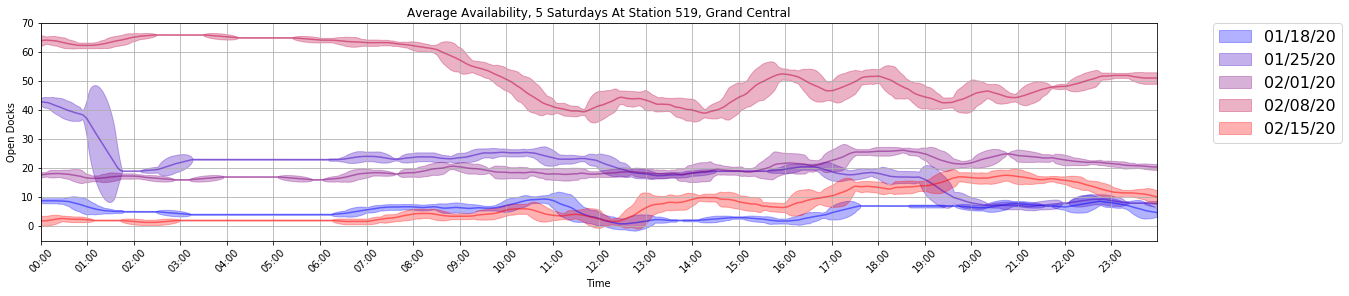

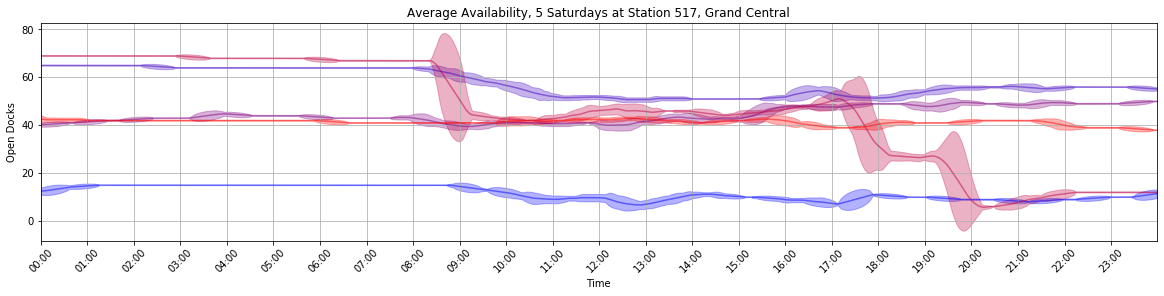

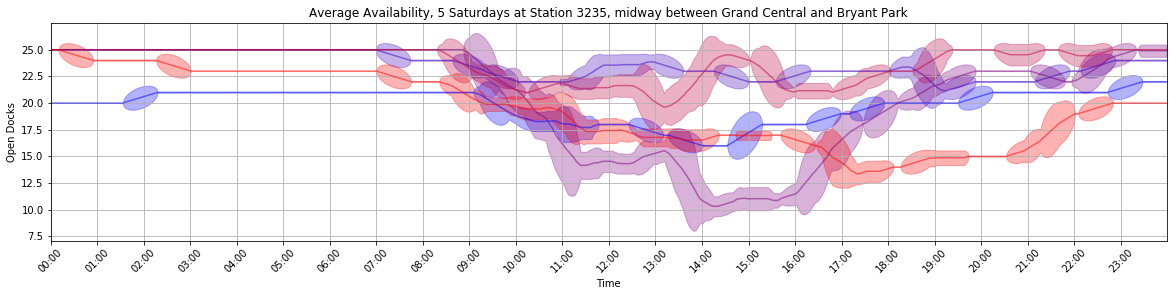

In [89]:
startday = '1/18/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 519
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub3settings()

patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))

plt.legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Average Availability, 5 Saturdays At Station 519, Grand Central')
# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )


  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

stationid = 517
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub3settings()

plt.title('Average Availability, 5 Saturdays at Station 517, Grand Central')
# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )


  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

stationid = 3235
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub3settings()

plt.title('Average Availability, 5 Saturdays at Station 3235, midway between Grand Central and Bryant Park')
# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )


  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

# Queuing

One thing that isn’t clear in the live data is queueing. At a station with zero docks available, a queue can form. When this happens, a newly opened dock (caused by someone else taking a bike from the station) will be filled immediately.

This phenomenon can be seen by looking at how recent the station data is…

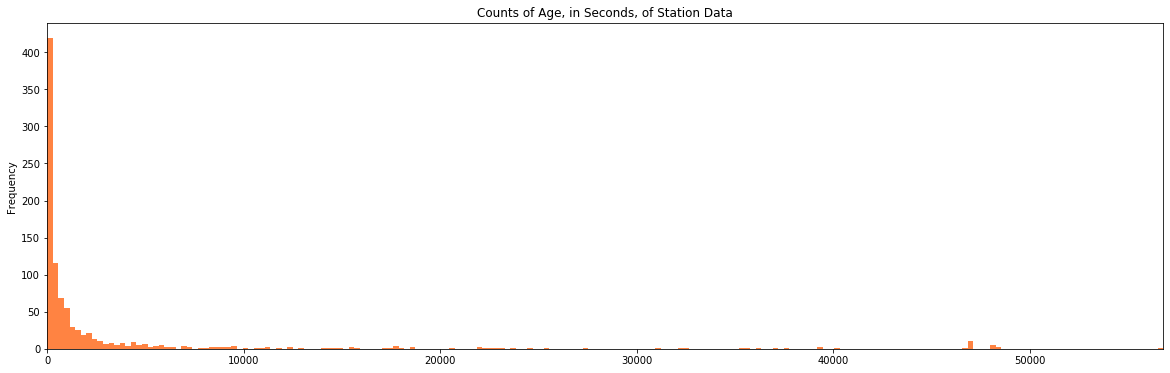

In [90]:
# Get current station status
r = requests.get('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')

staledata = r.json()

timenow = staledata["last_updated"]

stalereports = pd.DataFrame(staledata['data']['stations'])


stale = []
for x in range(0, len(list(stalereports['last_reported']))):
  stale.append(timenow - list(stalereports['last_reported'])[x])


plt.figure(figsize=(20, 6), dpi= 72)
plt.margins(x=0, y=.05)
plt.title('Counts of Age, in Seconds, of Station Data')

pd.Series(stale).plot(kind='hist', bins=200, color='#ff8342')

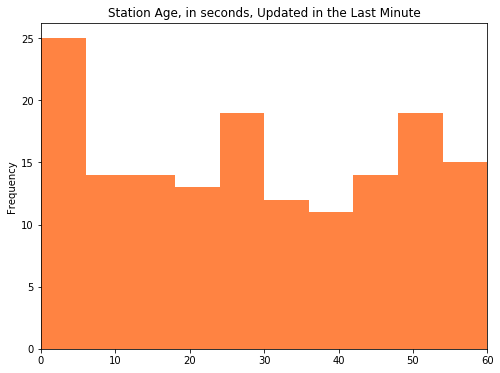

In [91]:
plt.figure(figsize=(8, 6), dpi= 72)
plt.margins(x=0, y=.05)
plt.title('Station Age, in seconds, Updated in the Last Minute') 

pd.Series(stale).plot(kind='hist', color='#ff8342', range=(0, 60), alpha=1)

# City Hall

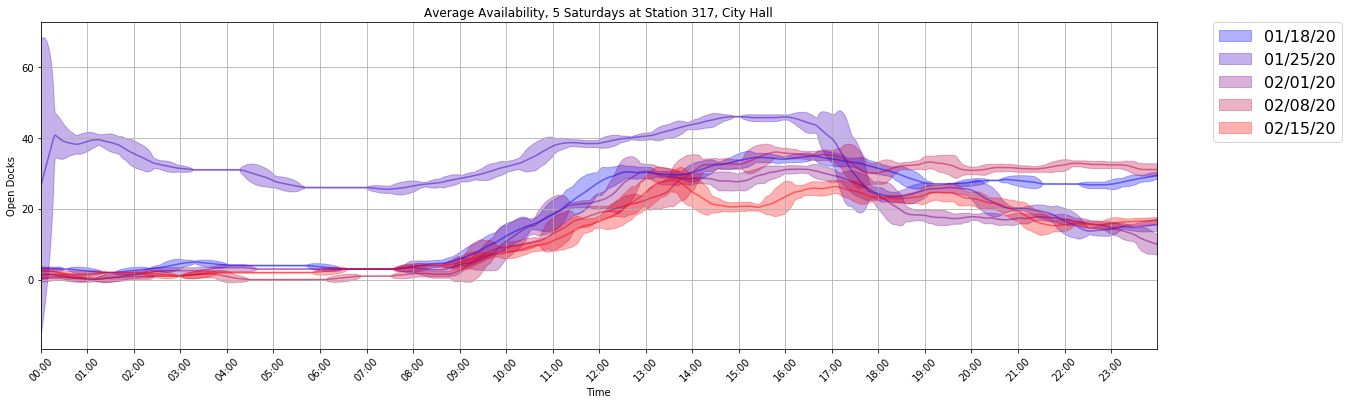

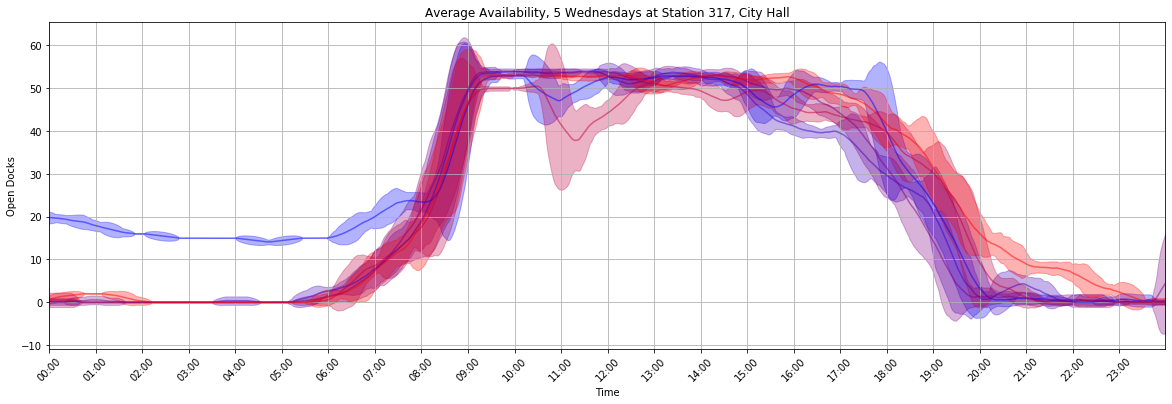

In [92]:
startday = '1/18/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 317
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub2settings()

patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))

plt.legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title('Average Availability, 5 Saturdays at Station 317, City Hall')


# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )
  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

startday = '1/22/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 317
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub2settings()

patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))

plt.title('Average Availability, 5 Wednesdays at Station 317, City Hall')


# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )
  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

# Speaking of Halls... Tammany!

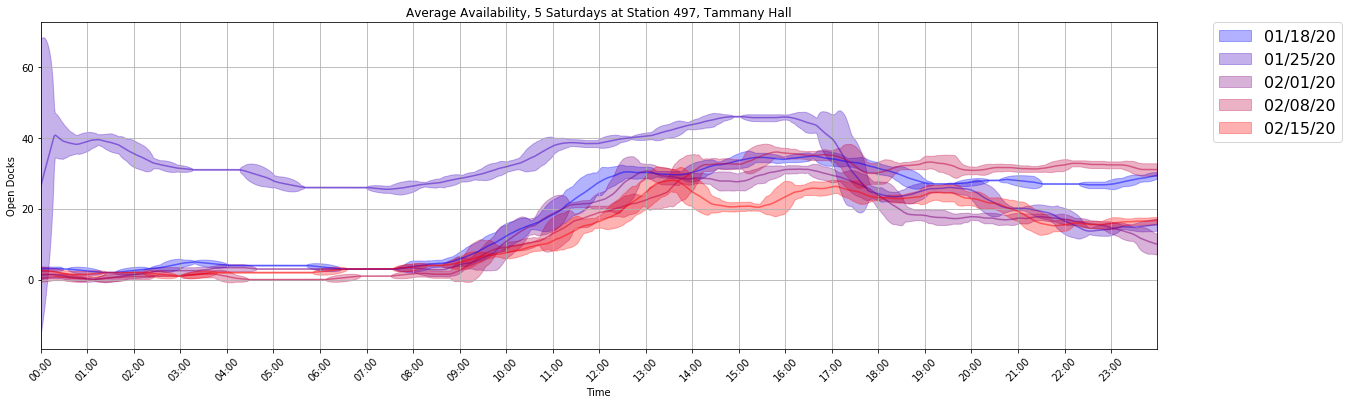

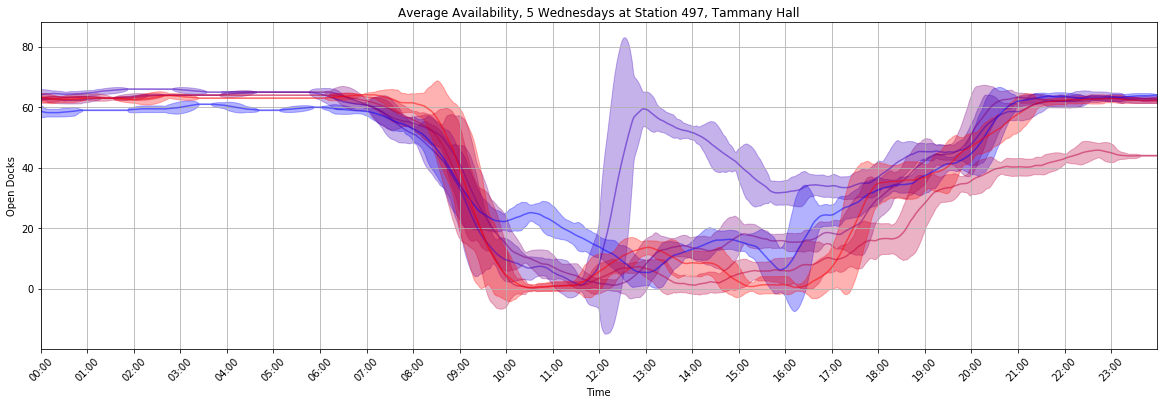

In [93]:
startday = '1/18/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 317
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub2settings()

patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))

plt.legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title('Average Availability, 5 Saturdays at Station 497, Tammany Hall')


# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )
  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )

startday = '1/22/20 00:00'
lateday = one_day_more(startday)
weeks = 4
endday = epoch_xweeks_from_day(startday, weeks)
stationid = 497
sigma = 2
timerange = [locreturn(mu45, startday), locreturn(mu45, month_day_time(lateday))]

sub2settings()

patches = []
for x in range(0, weeks + 1):
  patches.append(mpatches.Patch(color=hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x))),
                                alpha=.3,
                                label=month_day_year(epoch_xweeks_from_day(startday, x))
  ))


plt.title('Average Availability, 5 Wednesdays at Station 497, Tammany Hall')


# Stack days of week onto each other; ex. Saturday the 11th on Saturday the 18th, etc.
for x in range(0, weeks + 1):
  
  rowrange = [locreturn(mu45, month_day_time(epoch_xweeks_from_day(startday, x))),
              locreturn(mu45, month_day_time(epoch_xweeks_from_day(month_day_time(one_day_more(startday)), x)))]
  
  # Move the color along a spectrum
  hue = hex_color(int(((255 / weeks) * x)), 0, 255 - int(((255 / weeks) * x)))


  plt.fill_between(sigma45.index[timerange[0]:timerange[1]],
                  mu45[rowrange[0]:rowrange[1]][stationid] - (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  mu45[rowrange[0]:rowrange[1]][stationid] + (sigma * sigma45[rowrange[0]:rowrange[1]][stationid]),
                  color=hue,
                  alpha=.3
  )
  plt.plot(sigma45.index[timerange[0]:timerange[1]],
           mu45[rowrange[0]:rowrange[1]][stationid],
           color=hue,
           alpha=.5
  )